# Introduction

Experimentation on the [Dataset for ADL Recognition with a Wrist-worn Accelerometer](https://archive.ics.uci.edu/ml/datasets/Dataset+for+ADL+Recognition+with+Wrist-worn+Accelerometer).

In [1]:
import os, sys, shutil, glob, requests, zipfile
import numpy as np, sequentia as seq, matplotlib.pyplot as plt
import sequentia.classifiers, sequentia.preprocessing
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

# Import utility tools
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import *
from lstm import LSTMClassifier

# ggplot style
plt.style.use('ggplot')

# Set seed for reproducible randomness
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed)

## Downloading and deserializing the data

In [2]:
# A map of the gesture directories to their class names
directory_map = {
    'Brush_teeth': 'brush_teeth',
    'Climb_stairs*': 'climb_stairs',
    'Comb_hair': 'comb_hair',
    'Descend_stairs': 'descend_stairs',
    'Drink_glass*': 'drink_glass',
    'Eat_meat': 'eat_meat',
    'Eat_soup': 'eat_soup',
    'Getup_bed*': 'getup_bed',
    'Liedown_bed': 'liedown_bed',
    'Pour_water*': 'pour_water',
    'Sitdown_chair*': 'sitdown_chair',
    'Standup_chair*': 'standup_chair',
    'Use_telephone': 'use_telephone',
    'Walk*': 'walk'
}

classes = list(directory_map.values())

In [3]:
def file_to_numpy(file):
    """Convert acceleration parameter .txt file to np.ndarray"""
    with open(file) as f:
        X = []
        for line in f:
            Ax, Ay, Az = line.strip('\n').split()
            X.append([float(Ax), float(Ay), float(Az)])
    return np.array(X)

In [4]:
X, y = [], []
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00283/ADL_Dataset.zip'

try:
    path, zip_path = 'HMP_Dataset', 'ADL_Dataset.zip'
    print('Downloading dataset from {} ...'.format(url))
    response = requests.get(url)
    with open(zip_path, 'wb') as f:
        print('Writing {} ...'.format(zip_path))
        f.write(response.content)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print('Extracting {} ...'.format(zip_path))
        zip_ref.extractall()
except:
    raise
else:
    print('Reading data into Numpy arrays ...')
    for pattern, label in directory_map.items():
        for folder in glob.glob(os.path.join(path, pattern)):
            for txt in glob.glob(os.path.join(folder, '*.txt')):
                X.append(file_to_numpy(txt))
                y.append(label)
    print('Done!')
finally:
    os.remove(zip_path)
    shutil.rmtree(path)

Writing ADL_Dataset.zip ...
Extracting ADL_Dataset.zip ...
Reading data into Numpy arrays ...
Done!


# Dataset splits

1. Shuffle the dataset.
2. Create a 65-20-15 training, validation and test set split.

In [5]:
# Shuffle and split the data into training, validation and test sets (65-20-15)
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.35, shuffle=True, random_state=rng)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.43, shuffle=True, random_state=rng)

# Display the split sizes
print('Training set size: {}'.format(len(y_train)))
print('Validation set size: {}'.format(len(y_val)))
print('Test set size: {}'.format(len(y_test)))

Training set size: 636
Validation set size: 195
Test set size: 148


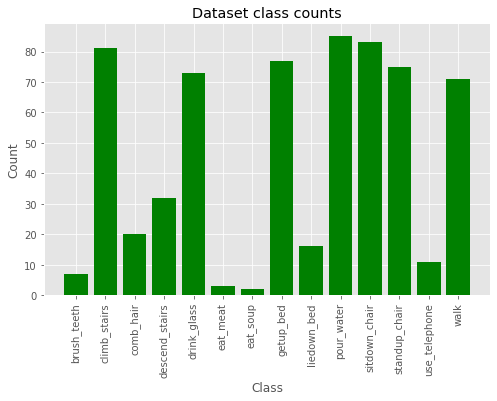

In [6]:
# Plot a chart of the class counts in the training set
show_class_counts(y_train, classes, rotate_xticks=True)

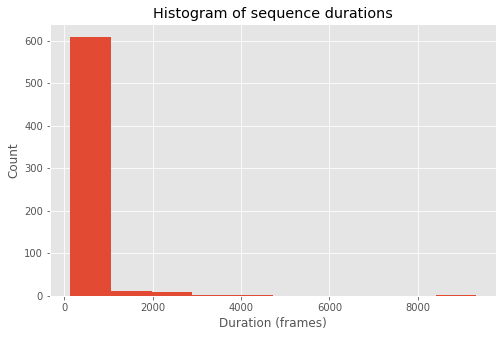

In [7]:
# Plot a histogram of signal durations
show_durations(X_train)

## Signal visualization

In [8]:
def plot_signal(signal, figsize=(7, 4), title=None):
    """Function for visualizing an accelerometer signal"""
    title = 'Accelerometer signals' if title is None else title
    labels = ['X', 'Y', 'Z']
    colors = ['blue', 'red', 'green']
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=figsize)
    for i, ax in enumerate(axs.flat):
        ax.plot(signal[:, i], label=labels[i], color=colors[i])
        ax.legend(loc='upper right')
    fig.tight_layout()
    fig.subplots_adjust(hspace=0, wspace=0, top=0.92)
    fig.suptitle(title)
    plt.show()

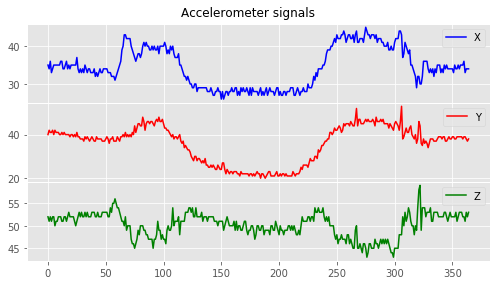

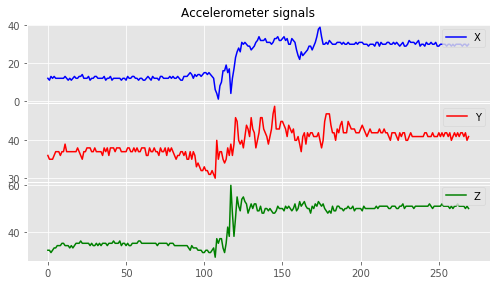

In [9]:
# Plot some sample accelerometer signals from the training set
for signal in X_train[:2]:
    plot_signal(signal)

## Approximate Dynamic Time Warping $k$-NN classifier

### Preprocessing

Classifying in the frequency domain worked better for $k$-NN.

In [10]:
# # Create a preprocessing pipeline for kNN
# knn_pre = seq.preprocessing.Preprocess()
# knn_pre.filtrate(n=5, method='median')
# knn_pre.downsample(n=5, method='decimate')
# knn_pre.standardize()
# knn_pre.fft()
# knn_pre.summary()

In [11]:
# # Plot the same sample accelerometer signals, but preprocessed
# for signal in knn_pre.transform(X_train[:2]):
#     plot_signal(signal)

In [12]:
# Apply the preprocessing pipeline to each dataset split
# X_train_knn, X_val_knn, X_test_knn = knn_pre.transform(X_train), knn_pre.transform(X_val), knn_pre.transform(X_test)

### Fitting the model

In [13]:
# Fit a DTWKNN classifier on the training data
# clf = seq.classifiers.DTWKNN(k=1, radius=1)
# clf.fit(X_train_knn, y_train)

### Evaluating the model

In [14]:
# %%time
# Classify the validation examples and display accuracy and confusion matrix
# acc, cm = clf.evaluate(X_val_knn, y_val, labels=classes, n_jobs=-1)
# show_results(acc, cm, dataset='validation', labels=classes)

## Hidden Markov Model classifier

### Preprocessing

In [59]:
# Create a preprocessing pipeline for HMMs
hmm_pre = seq.preprocessing.Preprocess()
hmm_pre.filtrate(n=10, method='median')
hmm_pre.downsample(n=5, method='decimate')
hmm_pre.standardize()
hmm_pre.summary()

           Preprocessing summary:          
1. Filtering:
   Median filter with window size (n=10)
-------------------------------------------
2. Downsampling:
   Decimation with downsample factor (n=10)
-------------------------------------------
3. Standardization


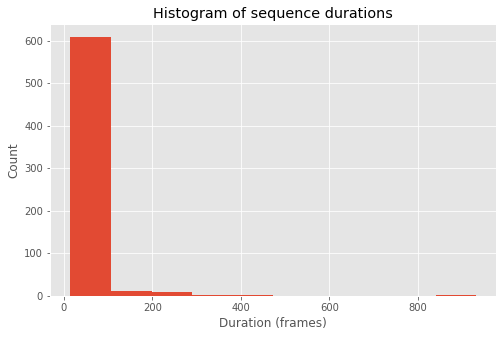

In [60]:
show_durations(hmm_pre.transform(X_train))

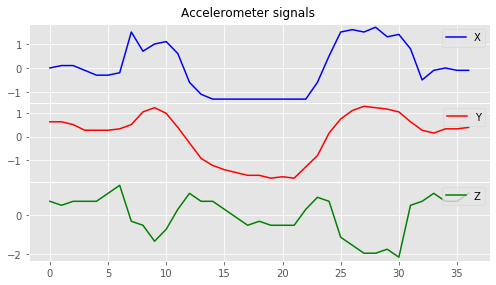

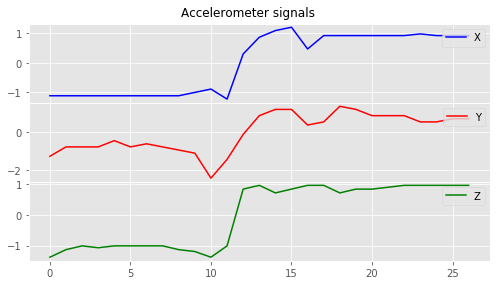

In [61]:
# Plot the same sample accelerometer signals, but preprocessed
for signal in hmm_pre.transform(X_train[:2]):
    plot_signal(signal)

In [62]:
# Apply the preprocessing pipeline to each dataset split
X_train_hmm, X_val_hmm, X_test_hmm = hmm_pre.transform(X_train), hmm_pre.transform(X_val), hmm_pre.transform(X_test)

### Fitting the model

In [63]:
%%time

# Create HMMs to represent each class
#
# NumPy sometimes raises some errors as a result of instability during the Cholesky decomposition.
# According to issue #414 on Pomegranate's GitHub repository, this may be caused by:
# - Too many states in the HMMs
# - Too many dimensions in the input data, which leads to a large covariance matrix
# - Too few training examples
hmms = []
for c in tqdm(classes, desc='Training HMMs'):
    hmm = seq.classifiers.HMM(label=c, n_states=10, random_state=rng)
    hmm.set_random_initial()
    hmm.set_random_transitions()
    hmm.fit([X_train[i] for i, label in enumerate(y_train) if label == c])
    hmms.append(hmm)
    
# Fit a HMM classifier with the HMMs
clf = seq.classifiers.HMMClassifier()
clf.fit(hmms)


CPU times: user 44.8 s, sys: 505 ms, total: 45.3 s
Wall time: 50.8 s


### Evaluating the model

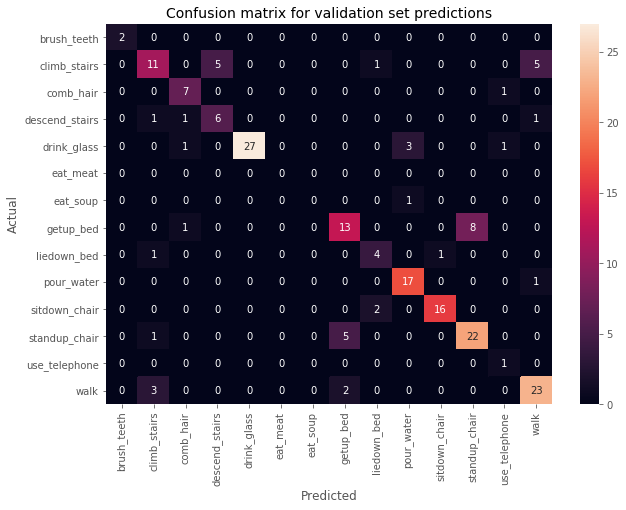

Accuracy: 76.41%
CPU times: user 1.79 s, sys: 443 ms, total: 2.24 s
Wall time: 2.52 s


In [64]:
%%time
# Classify the validation examples and display accuracy and confusion matrix
acc, cm = clf.evaluate(X_val_hmm, y_val, labels=classes)
show_results(acc, cm, dataset='validation', labels=classes)

## LSTM classifier

### Preprocessing

In [35]:
from sequentia.preprocessing import filtrate, center

def lstm_pre(XX):
    XX = filtrate(XX, n=10, method='median')
    XX = smart_downsample(XX, m=50, method='decimate')
    XX = center(XX)
    return XX

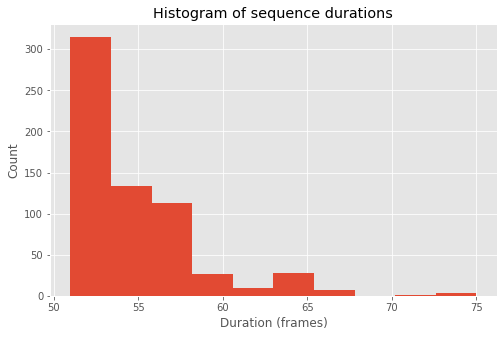

In [36]:
show_durations(lstm_pre(X_train))

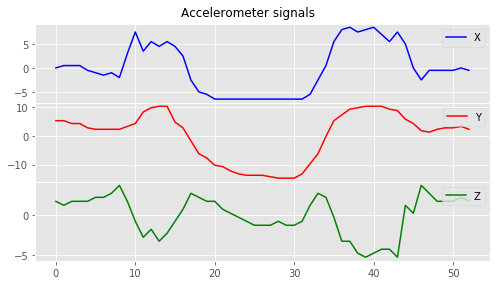

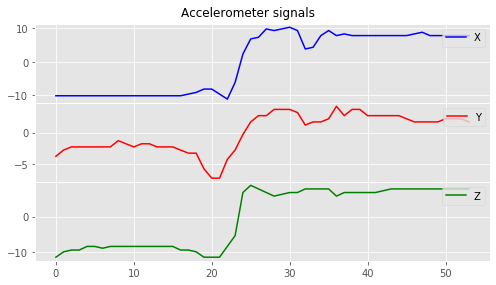

In [37]:
# Plot the same sample accelerometer signals, but preprocessed
for signal in lstm_pre(X_train[:2]):
    plot_signal(signal)

In [38]:
# Apply the preprocessing pipeline to each dataset split
X_train_lstm, X_val_lstm, X_test_lstm = lstm_pre(X_train), lstm_pre(X_val), lstm_pre(X_test)

### Fitting the model

In [43]:
%%time
from tensorflow.keras.optimizers import Adam
clf = LSTMClassifier(epochs=50, batch_size=256, optimizer=Adam(learning_rate=0.0015), classes=classes)
hist = clf.fit(X_train_lstm, y_train, validation_data=(X_val_lstm, y_val), return_history=True)

Train on 636 samples, validate on 195 samples
Epoch 1/50
636/636 [==============================] - 3s 4ms/sample - loss: 2.6153 - accuracy: 0.2248 - val_loss: 2.5650 - val_accuracy: 0.2667
Epoch 2/50
636/636 [==============================] - 1s 1ms/sample - loss: 2.5123 - accuracy: 0.2610 - val_loss: 2.3588 - val_accuracy: 0.2359
Epoch 3/50
636/636 [==============================] - 1s 1ms/sample - loss: 2.2359 - accuracy: 0.2516 - val_loss: 2.1293 - val_accuracy: 0.2359
Epoch 4/50
636/636 [==============================] - 1s 1ms/sample - loss: 2.0927 - accuracy: 0.2469 - val_loss: 2.0081 - val_accuracy: 0.2359
Epoch 5/50
636/636 [==============================] - 1s 1ms/sample - loss: 1.9285 - accuracy: 0.2579 - val_loss: 1.8861 - val_accuracy: 0.2103
Epoch 6/50
636/636 [==============================] - 1s 1ms/sample - loss: 1.8386 - accuracy: 0.2783 - val_loss: 1.7949 - val_accuracy: 0.2923
Epoch 7/50
636/636 [==============================] - 1s 1ms/sample - loss: 1.7663 - accur

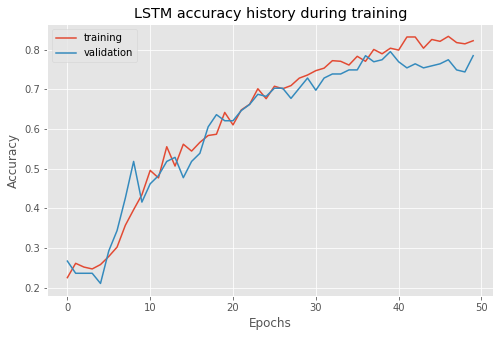

In [44]:
# Display accuracy history during training
show_accuracy_history(hist)

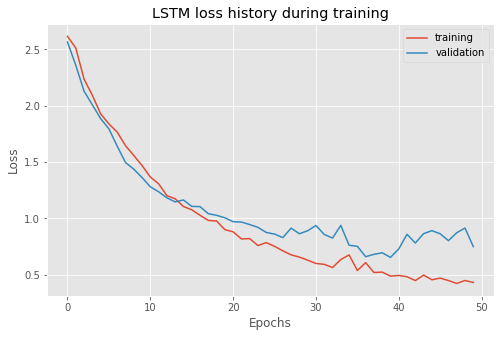

In [45]:
# Display loss history during training
show_loss_history(hist)

### Evaluating the model

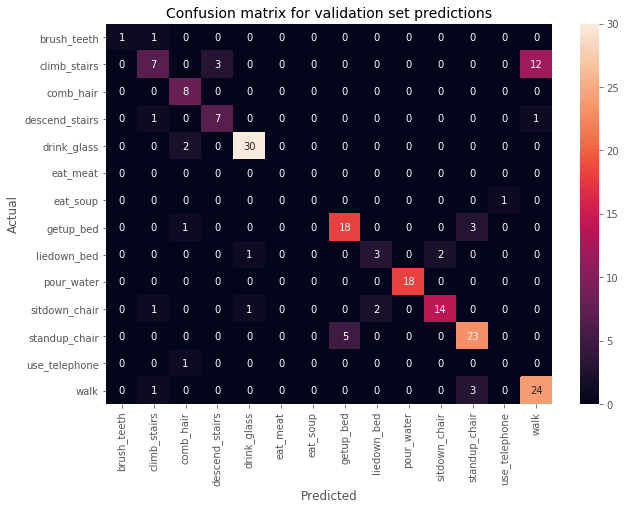

Accuracy: 78.46%
CPU times: user 1.72 s, sys: 140 ms, total: 1.86 s
Wall time: 2.04 s


In [46]:
%%time
acc, cm = clf.evaluate(X_val_lstm, y_val)
show_results(acc, cm, dataset='validation', labels=classes)